In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import shutil
import warnings
import random
import dlib
import cv2
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Path to the dataset directory
dataset_dir = '/CelebLikeMe/105_classes_pins_dataset(labelled)/Dark/'

In [5]:
# Function to load images from a given directory
def load_images_from_directory(directory):
    image_paths = []
    roots = []
    for root, _, files in os.walk(directory):
          roots.append(root)
          for file in files:
              if file.endswith('.jpg'):
                  image_paths.append(os.path.join(root, file))
    return image_paths

In [6]:
# Load image paths from the dataset
image_paths = load_images_from_directory(dataset_dir)

In [7]:
# Display a random sample of images with celebrity names
def display_random_sample(image_paths, num_samples=5):
    random_sample = random.sample(image_paths, num_samples)
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(random_sample):
        celebrity = image_path.split('/')[7]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(celebrity.replace("pins_", ''))  # Display celebrity name as title
    plt.suptitle('Random Sample of Images from the Dataset', fontsize=16)
    plt.show()


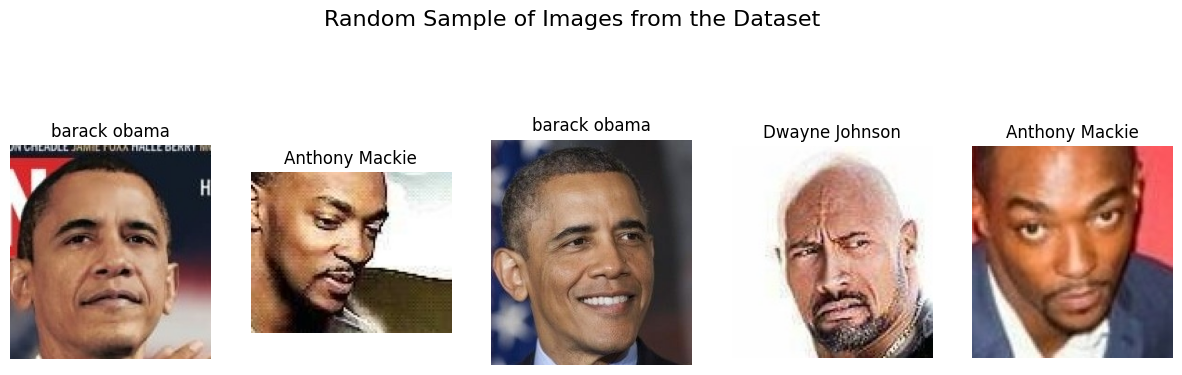

In [8]:
# Display a random sample of images with celebrity names
display_random_sample(image_paths)

In [9]:
# Count the number of images per celebrity
celeb_counts = {}
for image_path in image_paths:
    celebrity = image_path.split('/')[7]  # Extract celebrity name
    celebrity = celebrity.replace("pins_",'')
    celeb_counts[celebrity] = celeb_counts.get(celebrity, 0) + 1

# Sort the celebrities by the number of images they have
sorted_celebs = sorted(celeb_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 celebrities with the most images
top_5_celebs = sorted_celebs[:5]

# Extract celebrity names and image counts for the bar graph
celeb_names, image_counts = zip(*top_5_celebs)

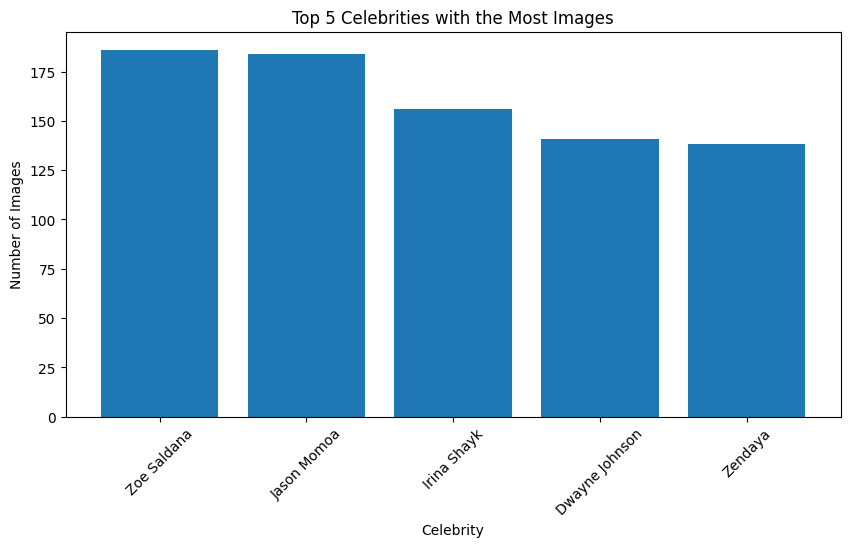

In [10]:
# Create a bar graph to show the top 5 celebrities with the most images
plt.figure(figsize=(10, 5))
plt.bar(celeb_names, image_counts)
plt.xlabel('Celebrity')
plt.ylabel('Number of Images')
plt.title('Top 5 Celebrities with the Most Images')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Get the dimensions of the dataset
num_images = len(image_paths)
image_shape = cv2.imread(image_paths[0]).shape

In [12]:
print(f"Number of Images in the Dataset: {num_images}")
print(f"Dimensions of Each Image: {image_shape}")


Number of Images in the Dataset: 1286
Dimensions of Each Image: (320, 302, 3)


In [13]:
# Initialize the face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor/shape_predictor_68_face_landmarks.dat')  # You need to download this model

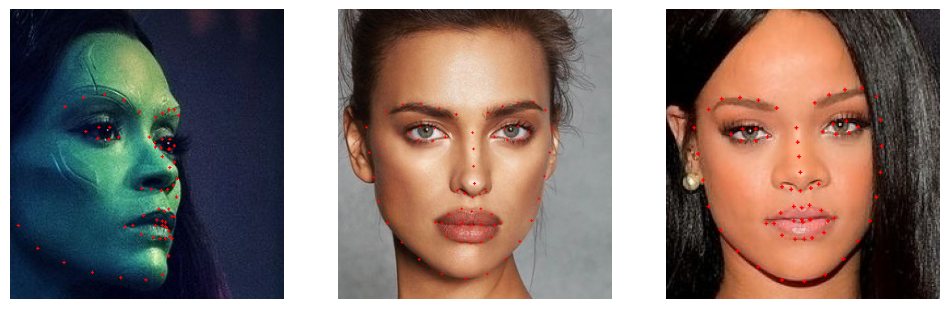

In [14]:
# Number of random samples to visualize
num_samples = 3

# Create a subplot grid for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

# Randomly select and visualize facial landmarks on sample images
for i in range(num_samples):
    # Randomly select an image
    random_image_path = random.choice(image_paths)

    # Load and process the selected image
    image = cv2.imread(random_image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Loop over detected faces and visualize facial landmarks
    for face in faces:
        landmarks = predictor(gray, face)
        landmarks = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)])

        # Draw landmarks on the image
        for (x, y) in landmarks:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    # Display the image with facial landmarks using Matplotlib
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Show the plotted images
plt.show()


In [15]:
# VGG Face model
model = Sequential()
# Block-1
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-2
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Fully connected layers
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))

# Flatten the output
model.add(Flatten())
model.add(Activation('softmax'))

In [16]:
model.load_weights('/CelebLikeMe/faceweights/vgg_face_weights.h5')

In [17]:
faceDescriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
# Initialize an empty array to store embeddings
num_samples = len(image_paths)
embedding_dim = 2622
embeddings = np.zeros((num_samples, embedding_dim))

# Loop through each image in the image_paths
for i, image_path in enumerate(image_paths):
    img_path = image_path

    # Load and preprocess the image
    img = cv2.imread(img_path, 1)
    img = img[..., ::-1]  # Convert from BGR to RGB
    img = (img / 255.).astype(np.float32)  # Normalize pixel values to [0, 1]
    img = cv2.resize(img, dsize=(224, 224))  # Resize the image to match model input size

    # Use the faceDescriptor model to extract embeddings
    embedding_vector = faceDescriptor.predict(np.expand_dims(img, axis=0))[0]

    # Store the embedding vector in the embeddings array
    embeddings[i] = embedding_vector
    print(i)

1/1 [==============================] - 8s 8s/step
0
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 20ms/step
2
1/1 [==============================] - 0s 20ms/step
3
1/1 [==============================] - 0s 33ms/step
4
1/1 [==============================] - 0s 47ms/step
5
1/1 [==============================] - 0s 103ms/step
6
1/1 [==============================] - 0s 107ms/step
7
1/1 [==============================] - 0s 99ms/step
8
1/1 [==============================] - 0s 79ms/step
9
1/1 [==============================] - 0s 35ms/step
10
1/1 [==============================] - 0s 26ms/step
11
1/1 [==============================] - 0s 29ms/step
12
1/1 [==============================] - 0s 48ms/step
13
1/1 [==============================] - 0s 59ms/step
14
1/1 [==============================] - 0s 34ms/step
15
1/1 [==============================] - 0s 51ms/step
16
1/1 [==============================] - 0s 43ms/step
17
1/1 [===============

In [ ]:
#Comment after First Use
np.save('/content/drive/MyDrive/Colab Notebooks/embeddings_dark.npy', embeddings)

In [18]:

embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/embeddings_dark.npy')

In [19]:
# Print the shape of the embeddings
print('Embeddings shape:', embeddings.shape)

Embeddings shape: (1286, 2622)


In [20]:
# Calculate the Euclidean distance between two embeddings.
def euclidean_distance(emb1, emb2):
    # Check if the input arrays have the same shape
    if emb1.shape != emb2.shape:
        raise ValueError("Input arrays must have the same shape")

    # Calculate the squared differences element-wise
    squared_diff = np.square(emb1 - emb2)

    # Sum the squared differences to get the Euclidean distance
    distance = np.sqrt(np.sum(squared_diff))

    return distance

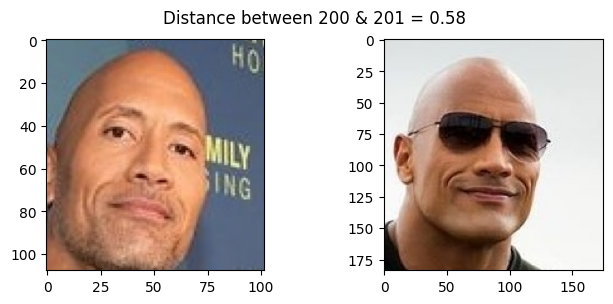

In [21]:
idx1 = 200
idx2 = 201

plt.figure(figsize=(8, 3))
plt.suptitle(f'Distance between {idx1} & {idx2} = {euclidean_distance(embeddings[idx1], embeddings[idx2]):.2f}')

plt.subplot(121)
plt.imshow(cv2.imread(image_paths[idx1], 1)[..., ::-1])

plt.subplot(122)
plt.imshow(cv2.imread(image_paths[idx2], 1)[..., ::-1])
plt.show()

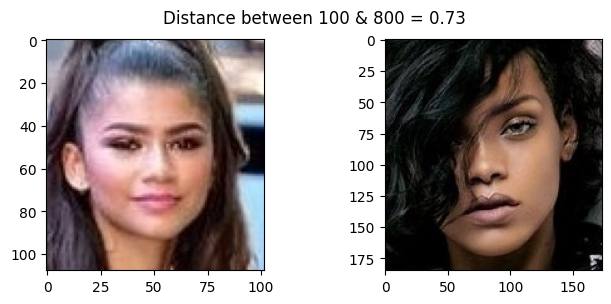

In [22]:
idx1 = 100
idx2 = 800

plt.figure(figsize=(8, 3))
plt.suptitle(f'Distance between {idx1} & {idx2} = {euclidean_distance(embeddings[idx1], embeddings[idx2]):.2f}')

plt.subplot(121)
plt.imshow(cv2.imread(image_paths[idx1], 1)[..., ::-1])

plt.subplot(122)
plt.imshow(cv2.imread(image_paths[idx2], 1)[..., ::-1])
plt.show()


In [23]:
labels = [image_path.split('/')[7].replace("pins_",'') for image_path in image_paths]
print(len(labels))

1286


In [24]:
# splititng the data for train and test
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1)

In [25]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(np.array(y_train).shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(np.array(y_test).shape[0]))

X_train shape : (1157,2622)
y_train shape : (1157,)
X_test shape : (129,2622)
y_test shape : (129,)


In [26]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features (X_train)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [28]:
# Reduce dimensions using PCA
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (1157,2622)
y_train_encoded shape : (1157,)
X_test_std shape : (129,2622)
y_test_encoded shape : (129,)


In [29]:
# Initialize PCA with the desired number of components (128 in this case)
pca = PCA(n_components=128)

# Fit and transform the standardized training features (X_train_std)
X_train_pca = pca.fit_transform(X_train_std)

# Transform the standardized test features (X_test_std) using the same PCA transformation
X_test_pca = pca.transform(X_test_std)

In [30]:
# Machine Learning Classifier
# Initialize the Support Vector Classifier with specified hyperparameters (C and gamma)
clf = SVC(C=5.0, gamma=0.001, probability=True)

In [31]:
# Fit the classifier to the training data with PCA-transformed features
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001, probability=True)

In [32]:
# Make predictions on the test data using the trained classifier
y_predict = clf.predict(X_test_pca)

In [33]:
y_predict

array([2, 6, 4, 0, 8, 2, 7, 1, 1, 2, 1, 6, 0, 6, 1, 4, 8, 7, 1, 0, 7, 3,
       3, 4, 1, 5, 2, 4, 3, 2, 0, 3, 1, 0, 7, 7, 5, 5, 7, 2, 1, 6, 6, 1,
       8, 3, 3, 2, 5, 1, 8, 8, 0, 8, 3, 8, 3, 8, 6, 7, 2, 2, 3, 7, 5, 7,
       2, 8, 3, 1, 3, 7, 0, 6, 3, 8, 1, 5, 7, 8, 3, 5, 7, 1, 0, 2, 2, 6,
       8, 5, 6, 2, 3, 4, 3, 2, 7, 0, 7, 7, 6, 0, 2, 6, 1, 1, 7, 6, 1, 3,
       5, 3, 2, 0, 7, 1, 3, 8, 2, 7, 0, 2, 6, 3, 6, 0, 6, 4, 8])

In [34]:
y_test_encoded

array([2, 6, 4, 0, 8, 2, 7, 1, 1, 2, 1, 6, 0, 6, 1, 4, 8, 7, 1, 0, 7, 3,
       3, 4, 1, 5, 2, 4, 3, 2, 0, 3, 1, 0, 7, 7, 5, 5, 7, 2, 1, 6, 6, 1,
       8, 3, 3, 2, 5, 1, 8, 8, 0, 8, 3, 8, 3, 8, 6, 7, 2, 2, 3, 7, 5, 7,
       2, 8, 3, 1, 3, 7, 0, 6, 3, 8, 1, 5, 7, 8, 3, 5, 7, 1, 0, 2, 2, 6,
       8, 5, 6, 2, 3, 4, 3, 2, 7, 0, 7, 7, 6, 0, 2, 6, 1, 1, 7, 6, 1, 3,
       5, 3, 2, 0, 7, 1, 3, 8, 2, 7, 0, 2, 6, 3, 6, 0, 6, 4, 8])

In [35]:
# Calculate accuracy score
accuracy = accuracy_score(y_test_encoded, y_predict)

# Calculate precision for each class
precision = precision_score(y_test_encoded, y_predict, average='weighted')

# Generate a classification report
classification_rep = classification_report(y_test_encoded, y_predict)

In [36]:
# Print the results
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Classification Report:\n", classification_rep)

Accuracy: 1.0
Precision (weighted): 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        14

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [37]:
# Load and preprocess the test image
img = cv2.imread(image_paths[41], 1)
img = img[..., ::-1]  # Convert from BGR to RGB
img = (img / 255.).astype(np.float32)  # Normalize pixel values to [0, 1]
img = cv2.resize(img, dsize=(224, 224))  # Resize the image to match model input size

# Use the faceDescriptor model to extract embeddings
embedding_vector = faceDescriptor.predict(np.expand_dims(img, axis=0))[0]

1/1 [==============================] - 8s 8s/step


In [38]:
scaledData = scaler.transform([embedding_vector])
pcaData = pca.transform(scaledData)

In [39]:
predictedLabel = clf.predict(pcaData)
predictedScore = clf.predict_proba(pcaData)

In [40]:
celebrityName = label_encoder.inverse_transform(predictedLabel)

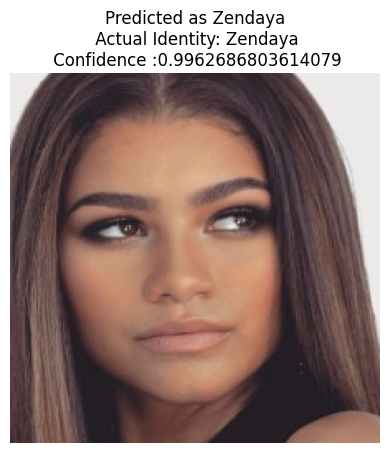

In [41]:
# Get the prediction and identity for the example
example_prediction = celebrityName[0]
example_identity = labels[41]

# Display the example image with a title
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted as {example_prediction}\n Actual Identity: {example_identity}\n Confidence :{max(predictedScore[0])}')
plt.show()


In [42]:
# save the neccessary model files
faceDescriptor.save("/vggModel_dark.pkl")
pickle.dump(scaler, open("/scaler_dark.pkl", "wb"))
pickle.dump(pca, open("/pca_dark.pkl", "wb"))
pickle.dump(clf, open("/svmModel_dark.pkl", "wb"))
pickle.dump(label_encoder, open("/label_encoder_dark.pkl", "wb"))